# Taskの依存関係
どのタスクの後(前)にどのタスクを実行するかという依存関係の構築について試す。

あるタスクA**より前**に実行されるべきタスクBがあったとする。この場合、タスクBをタスクAの**Upstream task**と呼ぶ。

また、あるタスクA**より後**に実行されるべきタスクCがあったとする。この場合、タスクCをタスクAの**Downstream task**と呼ぶ。

フローを構築する際に、タスクに対してupstream taskを指定することによって依存関係を構築できる。

In [1]:
## needs import
from prefect import task, Flow

[2021-09-18 19:19:09+0900] INFO - prefect.FlowRunner | Beginning Flow run for 'task-dependencies'
[2021-09-18 19:19:09+0900] INFO - prefect.TaskRunner | Task 'task_1': Starting task run...
task_1
[2021-09-18 19:19:09+0900] INFO - prefect.TaskRunner | Task 'task_1': Finished task run for task with final state: 'Success'
[2021-09-18 19:19:10+0900] INFO - prefect.TaskRunner | Task 'task_2': Starting task run...
task_2
[2021-09-18 19:19:10+0900] INFO - prefect.TaskRunner | Task 'task_2': Finished task run for task with final state: 'Success'
[2021-09-18 19:19:10+0900] INFO - prefect.TaskRunner | Task 'task_3_1': Starting task run...
task_3
[2021-09-18 19:19:10+0900] INFO - prefect.TaskRunner | Task 'task_3_1': Finished task run for task with final state: 'Success'
[2021-09-18 19:19:10+0900] INFO - prefect.TaskRunner | Task 'task_3_2': Starting task run...
task_4
[2021-09-18 19:19:10+0900] INFO - prefect.TaskRunner | Task 'task_3_2': Finished task run for task with final state: 'Success'
[2

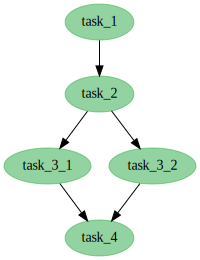

In [2]:
@task
def task_1():
    print("task_1")

@task
def task_2():
    print("task_2")

@task
def task_3_1():
    print("task_3")

@task
def task_3_2():
    print("task_4")

@task
def task_4():
    print("task_5")

with Flow("task-dependencies") as flow_task_dependencies:
    t1 = task_1()
    # task_1をtask_2のupstream_taskとして登録 (つまりtask_2はtask_1が完了してから実行される)
    t2 = task_2(upstream_tasks=[t1])
    # task_2をtask_3_1のupstream_taskとして登録 (つまりtask_3_1はtask_2が完了してから実行される)
    t3_1 = task_3_1(upstream_tasks=[t2])
    # task_2をtask_3_2のupstream_taskとして登録 (つまりtask_3_2はtask_2が完了してから実行される)
    t3_2 = task_3_2(upstream_tasks=[t2])
    # task_3_1とtask_3_2をtask_3_2のupstream_taskとして登録 (つまりtask_4はtask_3_1とtask_3_2が完了してから実行される)
    t4 = task_4(upstream_tasks=[t3_1, t3_2])

state = flow_task_dependencies.run()
flow_task_dependencies.visualize(flow_state=state)


# ▼ add_edgeを使ってDAGを組み立てるスタイル (↑と同様のFlowを構築している)
# with Flow('task-dependencies-other1') as flow_task_dependencies_other1:
#     flow_task_dependencies_other1.add_edge(task_1, task_2)
#     flow_task_dependencies_other1.add_edge(task_2, task_3_1)
#     flow_task_dependencies_other1.add_edge(task_2, task_3_2)
#     flow_task_dependencies_other1.add_edge(task_3_1, task_4)
#     flow_task_dependencies_other1.add_edge(task_3_2, task_4)
# flow_task_dependencies_other1.visualize()

タスクAが他のタスクBの結果(戻り値)を引数として受け取る場合、タスクBはタスクAのupstream taskとなる。(タスクAはタスクBのdownstream task)

[2021-09-18 19:19:10+0900] INFO - prefect.FlowRunner | Beginning Flow run for 'task-dependencies2'
[2021-09-18 19:19:10+0900] INFO - prefect.TaskRunner | Task 'add_1': Starting task run...
add_1 ->  2
[2021-09-18 19:19:10+0900] INFO - prefect.TaskRunner | Task 'add_1': Finished task run for task with final state: 'Success'
[2021-09-18 19:19:10+0900] INFO - prefect.TaskRunner | Task 'multiply_10': Starting task run...
multiply_10 ->  100
[2021-09-18 19:19:10+0900] INFO - prefect.TaskRunner | Task 'multiply_10': Finished task run for task with final state: 'Success'
[2021-09-18 19:19:10+0900] INFO - prefect.TaskRunner | Task 'to_arr': Starting task run...
task_3 ->  [2, 100]
[2021-09-18 19:19:10+0900] INFO - prefect.TaskRunner | Task 'to_arr': Finished task run for task with final state: 'Success'
[2021-09-18 19:19:10+0900] INFO - prefect.TaskRunner | Task 'show_sum': Starting task run...
sum ->  102
[2021-09-18 19:19:10+0900] INFO - prefect.TaskRunner | Task 'show_sum': Finished task ru

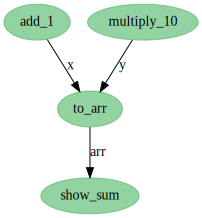

In [3]:
from typing import List
@task
def add_1(x: int) -> int:
    y = x + 1
    print("add_1 -> ", y)
    return y

@task
def multiply_10(x: int) -> int:
    y = x * 10
    print("multiply_10 -> ", y)
    return y

@task
def to_arr(x: int, y: int):
    arr = [x, y]
    print("task_3 -> ", arr)
    return arr

@task
def show_sum(arr: List[int]):
    s = sum(arr)
    print("sum -> ", s)

with Flow("task-dependencies2") as flow_task_dependencies2:
    t1_1 = add_1(1)
    t1_2 = multiply_10(10)
    # add_1(1)とmultiply_10(10)の結果を引数で受け取ることで、これらタスクはto_arrのupstream_taskとして登録される
    t2 = to_arr(t1_1, t1_2)
    t3 = show_sum(t2)
    
state = flow_task_dependencies2.run()
flow_task_dependencies2.visualize(flow_state=state)